# Route Inspection Problem
### (Chinese Postman Problem)

> To find the shortest closed path which visits every edge of a (connected) undirected graph.

## Conceptual Solution

A **Eulerian circuit** should exist in the graph: a closed-circuit path which visits every edge *exactly once*.

If such a circuit does not exist, generate that condition from the given graph: 

>Find the minimal set of the graph's edges to duplicate such that the resulting multigraph **does** have a Eulerian circuit.

The subset of edges must have the minimum possible total weight, or if edge weight is a non-factor, the smallest number of edges.

## Algorithm (generalised)

1. Find all nodes with an odd [degree](https://en.wikipedia.org/wiki/Degree_(graph_theory)).

2. Add edges to the graph such that odd-degree nodes become even-degree (accounts for and minimises backtracking): 
   
> any edges added must be duplicates of graph's original edges
    
> the added set of edges must have minimal total weight (np-hard)
    
3. Find the Eulerian circuit in the regenerated multigraph.

----

## Data Preparation

Gather dependencies:

In [297]:
# stdlib dependencies
import itertools
import copy

# external libraries
import networkx as nx
import pandas   as pd
import matplotlib.pyplot as plt

# animation rendering dependencies
import glob
import imageio
import numpy as np
import os

# inline animation display
from IPython.display import Image

Obtain external data:

> We use a dataset that maps connections/intersections between various hiking trails in Sleeping Giant Provincial Park (Ontario, Canada).

In [4]:
import io
import requests as r

NODE_CSV = 'https://gist.githubusercontent.com/brooksandrew/f989e10af17fb4c85b11409fea47895b/raw/a3a8da0fa5b094f1ca9d82e1642b384889ae16e8/nodelist_sleeping_giant.csv'
EDGE_CSV = 'https://gist.githubusercontent.com/brooksandrew/e570c38bcc72a8d102422f2af836513b/raw/89c76b2563dbc0e88384719a35cba0dfc04cd522/edgelist_sleeping_giant.csv'

nodes = pd.read_csv(io.StringIO(r.get(NODE_CSV).content.decode('utf-8')))
edges = pd.read_csv(io.StringIO(r.get(EDGE_CSV).content.decode('utf-8')))

Previewing data:

In [5]:
nodes

id     X     Y
0         b_bv  1486   732
1         b_bw   716  1357
2   b_end_east  3164  1111
3   b_end_west   141  1938
4          b_g  1725   771
..         ...   ...   ...
72       y_gy2  1939  1182
73        y_rc  1429  1491
74        y_rh   717  1852
75        y_rs  1805  1246
76        y_rt   977  1666

[77 rows x 3 columns]

In [6]:
edges

node1  node2 trail  distance        color  estimate
0    rs_end_north   v_rs    rs      0.30          red         0
1            v_rs   b_rs    rs      0.21          red         0
2            b_rs   g_rs    rs      0.11          red         0
3            g_rs   w_rs    rs      0.18          red         0
4            w_rs   o_rs    rs      0.21          red         0
..            ...    ...   ...       ...          ...       ...
118          v_bv   b_bv    bv      0.08       purple         0
119         g_gy2  w_gy2   gy2      0.05  yellowgreen         0
120         w_gy2  b_gy2   gy2      0.03  yellowgreen         1
121         b_gy2  o_gy2   gy2      0.07  yellowgreen         0
122         o_gy2  y_gy2   gy2      0.12  yellowgreen         0

[123 rows x 6 columns]

----

## Graph Creation

Begin by generating an empty graph:

In [10]:
g = nx.Graph()

Add edges and hydrate with edge attributes:

In [11]:
for _, row in edges.iterrows():
    g.add_edge(
        row[0],  # from node
        row[1],  # to node
        attr_dict=row[2:].to_dict()
    )

Now hydrate the graph with desired node attributes:

In [58]:
attrs = {
    row['id']: row[1:].to_dict()
    for _, row in nodes.iterrows()
}

nx.set_node_attributes(g, attrs)

In brief, the graph we've ended up with:

In [59]:
g.number_of_nodes(), g.number_of_edges()

(77, 123)

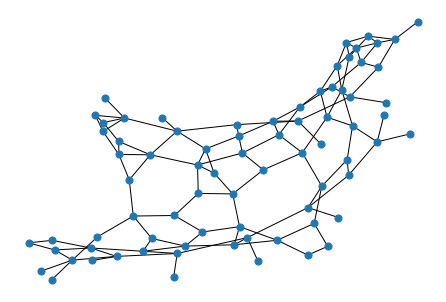

In [73]:
nx.draw(g, node_size=50)

----

## Visualization Prep

To control positional layout, first transcribe a `{node: (x, y), ...}` dictionary:

> `y` is negated so y-origin is at bottom-left, not top-left

In [74]:
node_positions = {
    nd: (g.nodes()[nd]['X'], -g.nodes()[nd]['Y'])
    for nd in g.nodes()
}

To control edge colour, gather that field from the provided data (wherein an edge belonging to a trail has that trail's colour):

In [75]:
edge_attr   = g.edges().values()
edge_colors = [e['attr_dict']['color'] for e in edge_attr] 

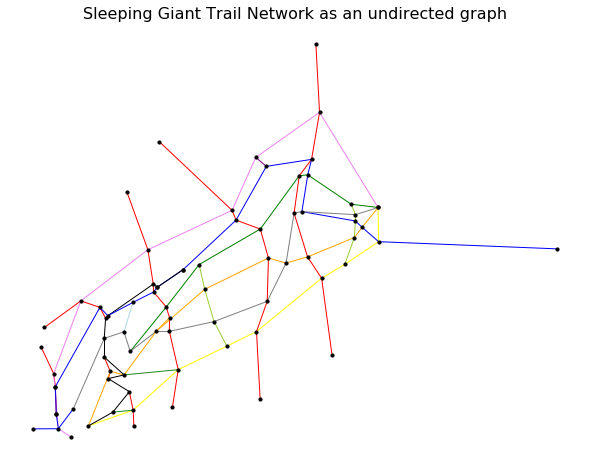

In [76]:
plt.figure(figsize=(8,6))

nx.draw(
    g,
    pos        = node_positions,
    edge_color = edge_colors,
    node_size  = 10,
    node_color = 'black'
)

plt.title('Sleeping Giant Trail Network as an undirected graph', size=16)
plt.show()

----

## Algorithm Implementation

1. **Find all nodes with an odd degree.**

In [77]:
odd_nodes = [node for node, degree in g.degree() if degree % 2]

f'Of {len(g.nodes())} total nodes, {len(odd_nodes)} have odd degree.'

'Of 77 total nodes, 36 have odd degree.'

----

2. **Compute the 'minimum' subset of edges that need to be duplicated to regenerate a graph where a Eulerian circuit can exist.**
    
    **a.** Compute all possible pair combinations of odd-degree nodes.
    
    **b.** Compute the shortest path between each node pair in `a`.
    
    **c.** Generate a [complete graph](https://en.wikipedia.org/wiki/Complete_graph) that connects each node pair from `a` with their respective shortest path attributes from `b`.
    
    **d.** Compute the [minimum weight matching](https://en.wikipedia.org/wiki/Matching_(graph_theory)) of `c`'s graph to obtain the minimum subset of the main graph's edges that need to be duplicated to allow a Eulerian circuit.
    
    **e.** "Add" the shortest path series between node pairs calculated in `d` to the main graph.

> **a.** compute all possible odd-degree nodes' pair combinations

In [78]:
odd_node_pairs = list(itertools.combinations(odd_nodes, 2))

> **b.** compute the shortest path between each node pair in `a`

In [79]:
weights = {}

for pair in odd_node_pairs:
    weights[pair] = nx.dijkstra_path_length(
        g,
        pair[0], pair[1],
        weight='distance'
    )

> **c.** generate a complete graph which connects each node pair from `a` with their respective shortest path attributes from `b`

In [80]:
cg = nx.Graph()

# flip weights because max weight matching algo is used, and we want min weights
for pair, w in weights.items():
        cg.add_edge(
            pair[0], pair[1],
            **{'distance': w, 'weight': -w}
        )

In [81]:
len(cg.nodes()), len(cg.edges())

(36, 630)

Let's pause and visualize the **complete graph** (fully connected graph) of odd-degree node pairs:

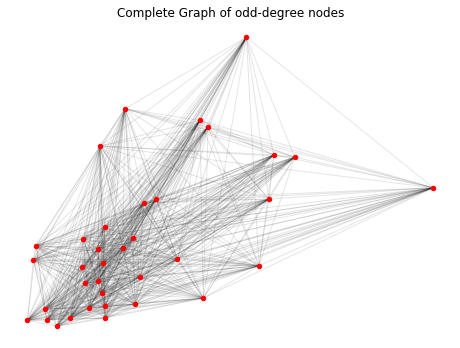

In [82]:
plt.figure(figsize=(8,5.85))

nx.draw_networkx_nodes(cg, node_positions, node_size=20, node_color='red')
nx.draw_networkx_edges(cg, node_positions, alpha=0.1)

plt.axis('off')
plt.title('Complete Graph of odd-degree nodes')
plt.show()

    
> **d.** compute the minimum weight matching of `c`'s complete graph to obtain the minimum subset of the main graph's edges that need to be duplicated

In [83]:
Mileage of circuit: 33.59duplicates = nx.algorithms.max_weight_matching(cg, maxcardinality=True)

SyntaxError: invalid syntax (<ipython-input-83-2a582ebd525f>, line 1)

We would expect 36 edges, but the algorithm output is already deduplicated for us:

In [84]:
len(duplicates)

18

Let's view and inspect our result.

*Remember that the paths shown are abstract connections between odd-degree nodes. Some match actual paths on the trail map, while some are just expressions of connection intent - but we'll get to that.*

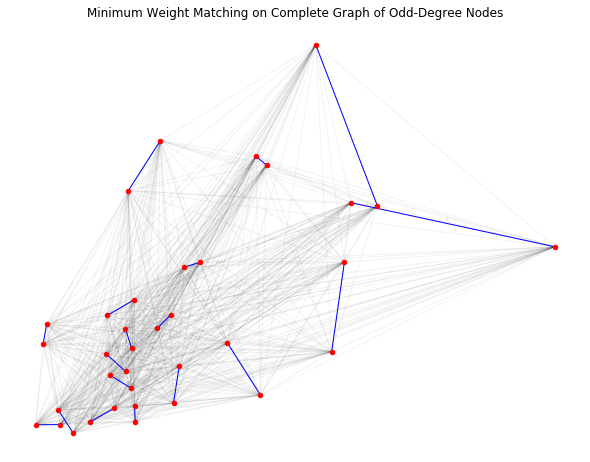

In [85]:
plt.figure(figsize=(8, 6))

# faintly redraw the complete graph above
nx.draw(
    cg,
    pos       = node_positions,
    node_size = 20,
    alpha     = 0.05    
)

# build and draw an overlay graph of the duplicate edges
dg = nx.Graph(list(duplicates))

nx.draw(
    dg,
    pos        = node_positions,
    node_size  = 20,
    edge_color = 'blue',
    node_color = 'red'
)

plt.title('Minimum Weight Matching on Complete Graph of Odd-Degree Nodes')
plt.show()

For a bit more clarity, we can overlay these abstract connections onto the actual trail map, to see which paths we will need to reconstruct:

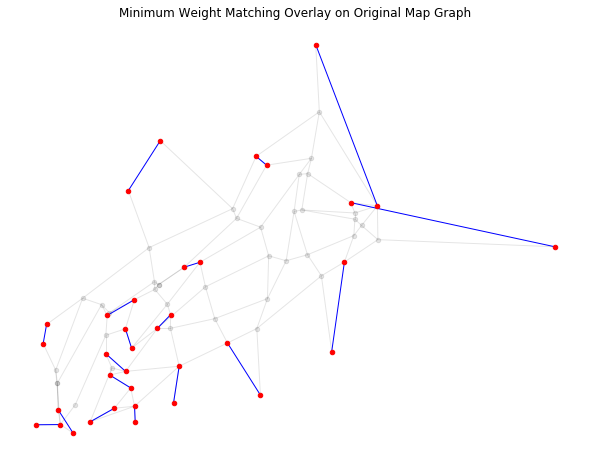

In [86]:
plt.figure(figsize=(8, 6))

# original trail map as graph
nx.draw(
    g,
    pos       = node_positions,
    node_size = 20,
    alpha     = 0.1,
    node_color= 'black'
)

# overlay of min weight match from complete graph of odd-degree nodes
nx.draw(
    dg,
    pos        = node_positions,
    node_size  = 20,
    alpha      = 1,
    node_color = 'red',
    edge_color = 'blue'
)

plt.title('Minimum Weight Matching Overlay on Original Map Graph')
plt.show()

> **e.** compute real paths from the connections expressed in `d`, and augment these to the main graph.

In [87]:
# a multigraph may have multiple edges between the same two nodes
augment = nx.MultiGraph(g.copy())

for pair in duplicates:
    augment.add_edge(
        pair[0], pair[1],
        attr_dict={
            'distance': nx.dijkstra_path_length(g, pair[0], pair[1]),
            'trail': 'augmented'
        }
    )

Let's verify that these 18 edges have been added,

In [88]:
len(augment.edges()) - len(g.edges()) == 18

True

and that every node in our graph now has an even degree:

In [89]:
pd.value_counts(list(dict(augment.degree()).values()))

4    54
2    18
6     5
dtype: int64

3. **Compute the Eulerian circuit (shortest path with each edge travelled only once).**

    **a.** resolve the abstract connection augments into real shortest paths on the actual trail map graph
    
    **b.** contextualise the circuit traversal with edge attributes so we can keep track of which edges have been walked already
    
    **c.** relax the assumption of starting and ending at the same node by beginning in an obvious place
    
    **d.** compute the correct circuit

> **pseudocode:**
    
- construct a naive Euler circuit of the *augmented* graph, and an empty 'actual' circuit

- begin looping through the naive Euler circuit

- for each edge that evolves in the naive circuit:
    + if the edge in the circuit step is 'real' (the path exists in the original trail map graph),
        - append it to the actual circuit
    + if the edge is an abstract connection (i.e. exists in the augmented graph but does not have a real corresponding edge in the original graph),
        - resolve it to the shortest path between those two nodes

In [90]:
def generate_euler_circuit(g_orig, g_aug, node_start=None):
    
    circuit       = []
    naive_circuit = list(nx.eulerian_circuit(g_aug, source=node_start))
    
    # naive_circuit: [(node_a, node_b), ...]
    for a, b in naive_circuit:
        
        edge_data = g_aug.get_edge_data(a, b)[0]
        
        if edge_data['attr_dict']['trail'] != 'augmented':
            # edge exists in original graph
            edge_attr = g_orig[a][b]
            circuit.append((a, b, edge_attr))
            
        else:
            aug_path       = nx.shortest_path(g_orig, a, b, weight='distance')
            aug_path_pairs = list(zip(aug_path[:-1], aug_path[1:]))
            
            print(
                f'Reconstructing abstract connection: ({a, b})\n'
                f'Augmenting with path: {" => ".join(aug_path)}\n'
                f'Augmenting path pairs: {aug_path_pairs}\n'
            )
            
            # find shortest path between nodes and sum edge dist attr
            for a_aug, b_aug in aug_path_pairs:
                edge_aug_attr = g_orig[a_aug][b_aug]
                circuit.append((a_aug, b_aug, edge_aug_attr))
                
    return circuit
        

In [105]:
# we'll start at the single node on the far east end
start = 'b_end_east'

circuit = generate_euler_circuit(g, augment, node_start=start)

Reconstructing abstract connection: (('b_end_east', 'g_gy2'))
Augmenting with path: b_end_east => b_y => park_east => g_gy2
Augmenting path pairs: [('b_end_east', 'b_y'), ('b_y', 'park_east'), ('park_east', 'g_gy2')]

Reconstructing abstract connection: (('y_gy2', 'rs_end_south'))
Augmenting with path: y_gy2 => y_rs => rs_end_south
Augmenting path pairs: [('y_gy2', 'y_rs'), ('y_rs', 'rs_end_south')]

Reconstructing abstract connection: (('y_gy1', 'rc_end_south'))
Augmenting with path: y_gy1 => y_rc => rc_end_south
Augmenting path pairs: [('y_gy1', 'y_rc'), ('y_rc', 'rc_end_south')]

Reconstructing abstract connection: (('g_gy1', 'b_tt_3'))
Augmenting with path: g_gy1 => g_rc => b_rc => b_tt_3
Augmenting path pairs: [('g_gy1', 'g_rc'), ('g_rc', 'b_rc'), ('b_rc', 'b_tt_3')]

Reconstructing abstract connection: (('rh_end_tt_1', 'b_bw'))
Augmenting with path: rh_end_tt_1 => b_tt_1 => b_bw
Augmenting path pairs: [('rh_end_tt_1', 'b_tt_1'), ('b_tt_1', 'b_bw')]

Reconstructing abstract connec

In [200]:
f'Our Euler circuit solution contains {len(circuit)} steps.'

'Our Euler circuit solution contains 154 steps.'

----

## Analysis

>But, the computer did it...

Let's take a look at some statistics of our graph and circuit to make sure they at least seem reasonable.

In [196]:
d_trails  = sum(e[2]['attr_dict']['distance'] for e in g.edges(data=True))
d_circuit = sum(e[2]['attr_dict']['distance'] for e in circuit)

_nc = pd.value_counts(pd.value_counts([e[0] for e in circuit]))
_ec = pd.value_counts(pd.value_counts([sorted(e)[0] + sorted(e)[1] for e in nx.MultiDiGraph(circuit).edges()]))

node_visits = pd.DataFrame({'visit count': _nc.index, '# nodes': _nc.values}).sort_values('visit count').to_string(index=False)
edge_visits = pd.DataFrame({'visit count': _ec.index, '# edges': _ec.values}).to_string(index=False)

In [201]:
print(
    '\n'.join([
        '\n'
        f'{d_trails:.2f}: total trail distance',
        f'{d_circuit:.2f}: total circuit distance',
        f'{d_circuit - d_trails:.3f}: retracing distance ({(d_circuit - d_trails)/d_trails:.2%})',
        '\n',
        f'{len(g.edges())} edges in original trail graph.',
        f'{len(circuit)} edges in Euler circuit through trails.',
        f' {len(circuit) - len(g.edges())} edges traversed more than once.',
        '\n'
    ])
)

print('Node visitation statistics:')
print(node_visits)

print('\nEdge traversal statistics:')
print(edge_visits)


25.76: total trail distance
34.15: total circuit distance
8.390: retracing distance (32.57%)


123 edges in original trail graph.
154 edges in Euler circuit through trails.
 31 edges traversed more than once.


Node visitation statistics:
 visit count  # nodes
           1       18
           2       42
           3       16
           4        1

Edge traversal statistics:
 visit count  # edges
           1       92
           2       31


----

## Visualisation

    'cause why not.

**a.** generate a deduplicated edge list (to visualise backtracking)

**b.** traverse the circuit, combining duplicate edges while tracking sequence and #visits

> **pseudocode:**

- create an empty edge dictionary

- begin looping through the Euler circuit, with enumeration

- for each enumerated edge,
    + if the edge is not already in the edge dictionary (easy deduplication),
        - add the edge as a key, with `visits=1` and `sequence=str({enumeration i})` as data
    + if the edge is already in the edge dictionary,
        - increment `visits` by 1, and append `, str({enumeration i})` to `sequence`

In [240]:
def generate_rinsp_edges(euler_circuit):
    
    e_deduped = {}
    
    for i, e in enumerate(euler_circuit):
        
        edge = frozenset([e[0], e[1]])  # immutably pin node pairs (pre-deduping keys)
        
        if edge in e_deduped:
            
            e_deduped[edge][2]['sequence'] += f', {str(i)}'
            e_deduped[edge][2]['visits']   += 1
            
        else:
            
            e_deduped[edge] = e
            
            e_deduped[edge][2]['sequence'] = str(i)
            e_deduped[edge][2]['visits']   = 1
    
    return list(e_deduped.values())
    

In [246]:
r_insp = generate_rinsp_edges(circuit)

rg = nx.Graph(r_insp)

The `r`oute `insp`ection edgelist is similar to the Euler circuit, and contains information about sequenced traversal:

In [263]:
r_insp[0]

('b_end_east',
 'b_y',
 {'attr_dict': {'trail': 'b',
   'distance': 1.32,
   'color': 'blue',
   'estimate': 0,
   'sequence': '0, 153',
   'visits': 2},
  'sequence': '0, 153',
  'visits': 2})

We can generate the "final" still-frame visualisation of the augmented graph, where the red-blue abstract connections are mapped out as paths:

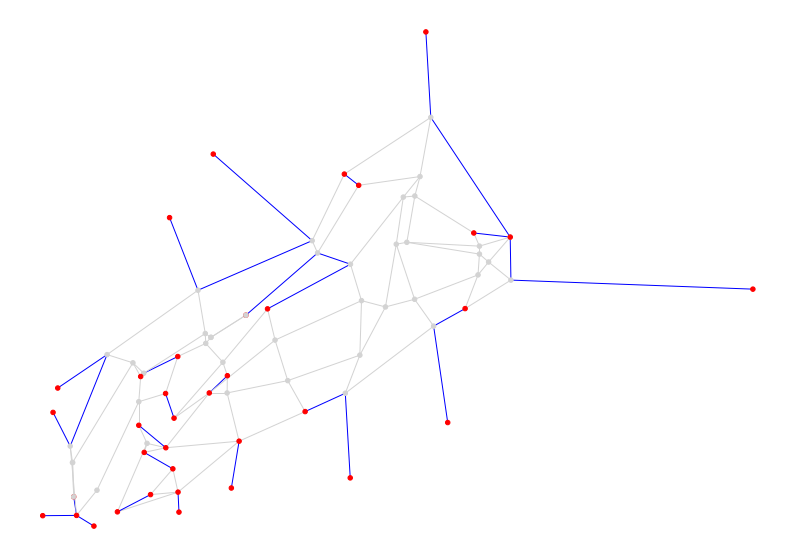

In [272]:
plt.figure(figsize=(14, 10))

# the only edges being backtracked are those in the 'real' paths of the augment subset
visit_colors = {1: 'lightgray', 2: 'blue'}

edge_colors = [visit_colors[e[2]['visits']] for e in rg.edges(data=True)]
node_colors = ['red' if node in odd_nodes else 'lightgray' for node in rg.nodes()]

nx.draw_networkx(
    rg,
    pos         = node_positions,
    node_size   = 20,
    node_color  = node_colors,
    edge_color  = edge_colors,
    with_labels = False
)

plt.axis('off')
plt.show()

And as well, the original trail map graph with sequence-numbered edges:

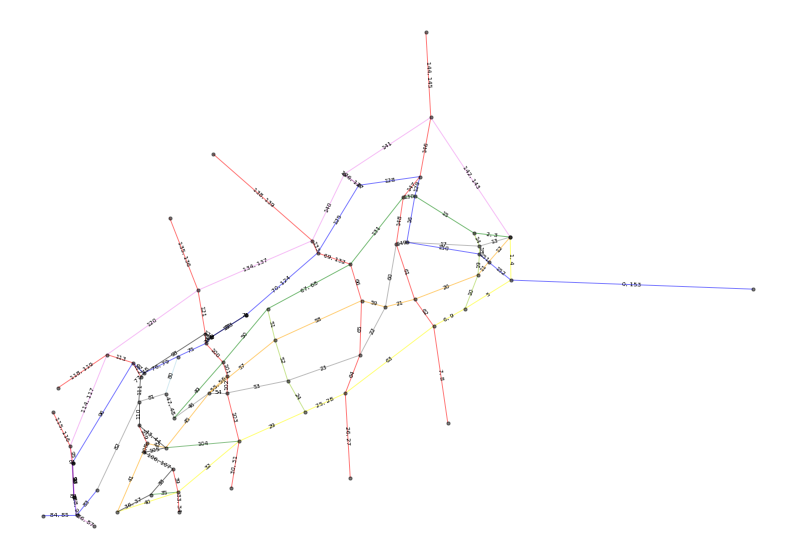

In [273]:
plt.figure(figsize=(14, 10))

edge_colors = [e[2]['attr_dict']['color'] for e in rg.edges(data=True)]
nx.draw_networkx(
    rg,
    pos         = node_positions,
    node_size   = 10,
    node_color  = 'black',
    edge_color  = edge_colors,
    with_labels = False,
    alpha       = 0.5
)

# cast text labels over edge line instead of breaking line
bounding = {'ec': [1,1,1,0], 'fc': [1,1,1,0]}

edge_labels = nx.get_edge_attributes(rg, 'sequence')
nx.draw_networkx_edge_labels(
    rg,
    pos         = node_positions,
    edge_labels = edge_labels,
    bbox        = bounding,
    font_size   = 6
)

plt.axis('off')
plt.show()

## Animation

    also why not

First, we need to configure and plot each frame, then save it as a still:

In [290]:
def generate_frames(euler_circuit):
    
    # show any revisited edges as red in animation
    visit_colors = {1: 'black', 2: 'red'}
    
    edge_counter      = {}
    frame_edge_colors = []
    
    # same as stillframe, but with circuit copies as frame generators
    for i, e in enumerate(euler_circuit, start=1):
        
        edge = frozenset([e[0], e[1]])
        
        if edge in edge_counter:
            edge_counter[edge] += 1
        else:
            edge_counter[edge]  = 1
            
        # faintly draw full graph in background
        nx.draw_networkx(
            rg,
            pos         = node_positions,
            node_size   = 6,
            node_color  = 'gray',
            with_labels = False,
            alpha       = 0.05
        )
        
        # get edges traversed by all iterations < i
        #     - since our enum start is 1, slice is current
        _circuit = copy.deepcopy(euler_circuit[0:i])
        
        for n in range(len(_circuit)):
            
            _edge = frozenset([_circuit[n][0], _circuit[n][1]])
            
            _circuit[n][2]['_visits'] = edge_counter[_edge]
            
        _g = nx.Graph(_circuit)
        _g_edge_colors = [visit_colors[e[2]['_visits']] for e in _g.edges(data=True)]
        
        nx.draw_networkx_nodes(
            _g,
            pos         = node_positions,
            node_size   = 6,
            node_color  = 'lightgray',
            with_labels = False,
            alpha       = 0.6
        )
        
        nx.draw_networkx_edges(
            _g,
            pos        = node_positions,
            edge_color = _g_edge_colors,
            alpha      = 0.8
        )
        
        plt.axis('off')
        plt.savefig(f'./rinsp/stills/{i}.png', dpi=120, bbox_inches='tight')
        # print(f'Wrote frame {i}')
        plt.close()

    print(f'Complete! Rendered and wrote {len(euler_circuit)} frames.')

In [291]:
generate_frames(circuit)

Complete! Rendered and wrote 154 frames.


Then, we take the stillframes and render them to a gif (hard G):

In [294]:
def render_animation(stills_dir, anim_filename, fps=5):
    
    # collect sorted list of filenames
    fs      = glob.glob(stills_dir + '*.png')
    fs_sort = np.argsort(
        [int(os.path.basename(f).split('.')[0]) for f in fs]
    )
    
    # comprehensions are all or nothing, so reassignment is safe-ish
    fs = [fs[i] for i in fs_sort]
    
    # movie magic
    with imageio.get_writer(anim_filename, mode='I', fps=fps) as w:
        
        for f in fs:
            img = imageio.imread(f)
            w.append_data(img)

In [296]:
render_animation('./rinsp/stills/', './rinsp/anim.gif')

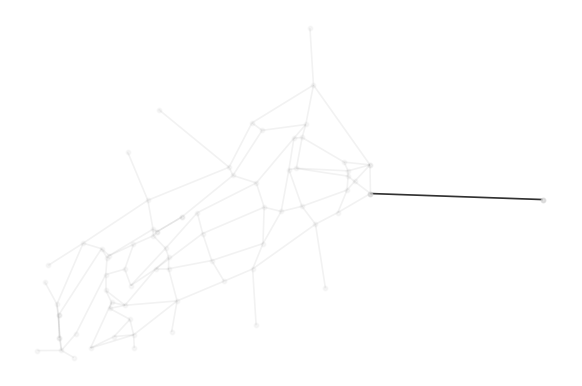

In [299]:
Image(filename='./rinsp/anim.gif')